<a href="https://colab.research.google.com/github/medhhaa/Bank-Churn-Prediction/blob/main/Bank_Churner_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Problem

A business manager of a consumer credit card portfolio is facing a steady loss of customers and wants to understand why

**Data Source:**  
[Kaggle: Credit Card Customers](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers/data)

The dataset captures:  
- **Demographics:** age, income, marital status  
- **Account details:** credit limit, card category  
- **Engagement metrics:** months on book, contacts in the last 12 months  

Currently **16.07%** of customers have churned, leading to lost fee income, reduced cross-sell opportunities, and higher acquisition costs

**Goal:**  
Identify the factors driving attrition and build a model that predicts which customers are most at risk of leaving. With those insights, the bank can proactively engage high-risk segments with targeted offers, service enhancements, and personalized outreach, ultimately lowering churn, increasing customer lifetime value, and making retention spending more efficient.


### 1.1 Import Libraries

In [3]:
pip install scikit-plot

In [4]:
# Import Libraries

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Interactive visualizations
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import plotly.io as pio
pio.renderers.default = 'colab'

# sns.set_style('darkgrid')
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
import scipy
# re‑add interp back into scipy
scipy.interp = np.interp
import scikitplot as skplt

plt.rc('figure', figsize = (18, 9))

In [5]:
# %pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

### 1.2 Load Data

In [6]:
df = pd.read_csv('BankChurners.csv')
df = df[df.columns[:-2]]
df.head(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

Inference: The data does not have any missing values.

### Understanding Dataset

- **CLIENTNUM**: Client number. Unique identifier for the customer holding the account  
- **Attrition_Flag**: Internal event (customer activity) variable – if the account is closed then 1 else 0  
- **Customer_Age**: Demographic variable – customer’s age in years  
- **Gender**: Demographic variable – M = Male, F = Female  
- **Dependent_count**: Demographic variable – number of dependents  
- **Education_Level**: Demographic variable – highest educational qualification of the account holder (e.g., high school, graduate, etc.)  
- **Marital_Status**: Demographic variable – Married, Single, Divorced, Unknown  
- **Income_Category**: Demographic variable – annual income bracket (< $40K, $40K–$60K, $60K–$80K, $80K–$120K, > $120K)  
- **Card_Category**: Product variable – type of card (Blue, Silver, Gold, Platinum)  
- **Months_on_book**: Relationship variable – number of months the customer has held the account  
- **Total_Relationship_Count**: Relationship variable – total number of products held by the customer  
- **Months_Inactive_12_mon**: Activity variable – number of months inactive in the last 12 months  
- **Contacts_Count_12_mon**: Engagement variable – number of contacts in the last 12 months  
- **Credit_Limit**: Financial variable – credit limit on the credit card  
- **Total_Revolving_Bal**: Financial variable – total revolving balance on the credit card  
- **Avg_Open_To_Buy**: Financial variable – average open-to-buy credit line over the last 12 months  
- **Total_Amt_Chng_Q4_Q1**: Behavioral variable – change in transaction amount (Q4 over Q1)  
- **Total_Trans_Amt**: Behavioral variable – total transaction amount in the last 12 months  
- **Total_Trans_Ct**: Behavioral variable – total transaction count in the last 12 months  
- **Total_Ct_Chng_Q4_Q1**: Behavioral variable – change in transaction count (Q4 over Q1)  
- **Avg_Utilization_Ratio**: Utilization variable – average card utilization ratio (revolving balance ÷ credit limit)


##2. Exploratory Data Analysis

### Customer Age

In [8]:
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import plotly.io as pio
pio.renderers.default = 'colab'

# Plotly makes interactive graphs

# Exploring age feature distribution
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = df['Customer_Age'], name = 'Age Box Plot', boxmean = True)
tr2 = go.Histogram(x = df['Customer_Age'], name = 'Age Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of Customer Ages")
fig.show()

Inference: The customer age distribution seems to be fairly normally distributed. Thus, we can apply the normality assumption to further utilize the age feature.

### Gender And Different Card Statuses

In [9]:
# Exploring Distribution Of Gender And Different Card Statuses
fig = make_subplots(
    rows = 2, cols = 2, subplot_titles = ('', '<b>Platinum Card Holders', '<b>Blue Card Holders<b>', 'Residuals'),
    vertical_spacing = 0.09,
    specs = [[{"type": "pie", "rowspan": 2}, {"type": "pie"}],
           [None, {"type": "pie"}]
          ]
)

fig.add_trace(
    go.Pie(values = df.Gender.value_counts().values, labels = ['<b>Female<b>', '<b>Male<b>'], hole = 0.3, pull = [0, 0.3]),
    row = 1, col = 1
)

fig.add_trace(
    go.Pie(
        labels = ['Female Platinum Card Holders', 'Male Platinum Card Holders'],
        values = df.query('Card_Category == "Platinum"').Gender.value_counts().values,
        pull = [0, 0.05, 0.5],
        hole = 0.3

    ),
    row = 1, col = 2
)

fig.add_trace(
    go.Pie(
        labels = ['Female Blue Card Holders', 'Male Blue Card Holders'],
        values = df.query('Card_Category == "Blue"').Gender.value_counts().values,
        pull = [0, 0.2, 0.5],
        hole = 0.3
    ),
    row = 2, col = 2
)

fig.update_layout(
    height = 800,
    showlegend = True,
    title_text = "<b>Distribution Of Gender And Different Card Statuses<b>",
)

fig.show()

Inference: The dataset has more 5.8% more women than men, but over all, the percentage is not higher and hence we can infer that the genders are pretty uniformly distributed.

### Dependent Count

In [10]:
# Dependent Count
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = df['Dependent_count'], name = 'Dependent count Box Plot', boxmean = True)
tr2 = go.Histogram(x = df['Dependent_count'], name = 'Dependent count Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of Dependent counts (close family size)")
fig.show()

Inference: Even this distribution of Dependent counts is fairly normally distributed with a slight right skew.

### Education Level

In [11]:
ex.pie(df, names = 'Education_Level', title = 'Propotion Of Education Levels', hole = 0.33)

Inference: On the assumption that unknown status lack education, we can still say that more than 70% of the customers have a formal education level. About 35% of customer have a higher level of education.

### Marital Status

In [12]:
ex.pie(df, names = 'Marital_Status', title = 'Propotion Of Marital Status', hole = 0.33)

Inference: Almost half of the bank customers are married and interestingly enough, almost the entire half are single. Only about 7% of the customers are divorced, which is surprising considering the worldwide divorce rate statistics!

### Income Status

In [13]:
ex.pie(df, names = 'Income_Category', title = 'Propotion Of Income Categories', hole = 0.33)

Illustration of various Income categories of the bank customers. It will be interesting to know the correlation of income and their churn, defaults status. There's a high percentage of the customers earning less than 40k!

In [14]:
# Analyze the distribution of Income_Category
income_counts = df['Income_Category'].value_counts()
print("Income Category Distribution:")
print(income_counts)

# Visualize the distribution using Plotly
fig = ex.bar(x = income_counts.index, y = income_counts.values,
              labels = {'x': 'Income Category', 'y': 'Frequency'},
              title = 'Distribution of Income Categories')
fig.update_layout(xaxis = {'categoryorder':'total descending'}) # Optional: order bars by frequency
fig.show()

# A simple visual inspection for Power Law characteristics:
# Check if there's a clear "long tail" - a few categories with high counts
# and many with low counts.
# Note: A formal test for Power Law distribution would require more sophisticated methods
# like fitting the data to a Power Law function and evaluating the fit.

Income Category Distribution:
Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64


I was curious to see if it follows a Power Law distribution or Log Normal distribution, but I skipped that such distributions need to have contnuous values rather than values in range.

### Card Category

In [15]:
ex.pie(df, names = 'Card_Category', title = 'Propotion Of Card Categories', hole = 0.33)

In [16]:
# Calculate the frequency of each card category
card_counts = df['Card_Category'].value_counts()
print("Card Category Distribution:")
print(card_counts)

# Visualize the distribution using Plotly (Bar Plot)
fig = ex.bar(x = card_counts.index, y = card_counts.values,
              labels = {'x': 'Card Category', 'y': 'Frequency'},
              title = 'Distribution of Card Categories')
fig.update_layout(xaxis = {'categoryorder':'total descending'})
fig.show()

Card Category Distribution:
Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64


In [17]:
# Calculate the total number of customers
total_customers = card_counts.sum()

# Calculate the percentage of customers in each card category
card_percentages = (card_counts / total_customers) * 100

print("Card Category Distribution (Percentages):")
print(card_percentages)

# Calculate the percentage of 'Blue' cardholders
blue_percentage = card_percentages['Blue']

# Calculate the percentage of all other cardholders
other_percentages = card_percentages.drop('Blue').sum()

print(f"\nPercentage of 'Blue' cardholders: {blue_percentage:.2f}%")
print(f"Percentage of other cardholders: {other_percentages:.2f}%")

if blue_percentage >= 80 and other_percentages <= 20:
    print("\nBased on these percentages, the distribution for 'Blue' vs. other categories is close to the 80-20 rule.")
else:
    print("\nBased on these percentages, the distribution for 'Blue' vs. other categories does not strictly follow the 80-20 rule.")

Card Category Distribution (Percentages):
Card_Category
Blue        93.176656
Silver       5.480399
Gold         1.145453
Platinum     0.197492
Name: count, dtype: float64

Percentage of 'Blue' cardholders: 93.18%
Percentage of other cardholders: 6.82%

Based on these percentages, the distribution for 'Blue' vs. other categories is close to the 80-20 rule.


### Months how long the customers have been a part of the bank

In [18]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = df['Months_on_book'], name = 'Months on book Box Plot', boxmean = True)
tr2 = go.Histogram(x = df['Months_on_book'], name = 'Months on book Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of months the customer is part of the bank")
fig.show()

Even though the distribution appeared to be more spread out, we cannot make assumption for normality by visualization alone. Hence, we will now examine kurtosis and skewness to determine the normality of this variable.

In [19]:
# The textbook definition usually has the values compared to =, > or < 3,
# But, kurt() gives excess Kurtosis (using Fischer's defn of Kurtosis)
# So, values closer to 0 are normally distributed.
print('Kurtosis of Months on book features is : {}'.format(df['Months_on_book'].kurt()))

Kurtosis of Months on book features is : 0.40010012019986707


For reference:

**Kurtosis** tells us about the "tailedness" and peakedness of a distribution compared to a normal distribution.

*   **Mesokurtic**: Similar to normal (kurtosis close to 0, or 3 for standard kurtosis).
*   **Leptokurtic**: Higher kurtosis (>0), fatter tails, sharper peak.
*   **Platykurtic**: Lower kurtosis (<0), thinner tails, flatter peak.

**Skewness** measures how symmetrical a distribution is. It tells us if the data is leaning to one side.

*   **Zero Skewness:** Symmetric distribution (like a bell curve). Skewness value is close to 0.
*   **Positive Skewness:** The tail is longer on the right side. Data is clustered on the left. Skewness value is positive (> 0).
*   **Negative Skewness:** The tail is longer on the left side. Data is clustered on the right. Skewness value is negative (< 0).

In [20]:
# Calculate the skewness of the 'Months_on_book' feature
skewness = df['Months_on_book'].skew()

print(f"The skewness of 'Months_on_book' is: {skewness:.4f}")

The skewness of 'Months_on_book' is: -0.1066


Inference: Based on a kurtosis of 0.4 (mesokurtic) and skewness of -0.1066 (nearly symmetric), along with visual inspection, the 'Months_on_book' distribution is not perfectly normal but is reasonably close. It can likely be treated as approximately normally distributed for most analyses. (This serves as a perfect reminder to not rely on visualizations alone!)

### Total Relationship Count portraying the No. Of Profucts Held By Customer

In [21]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = df['Total_Relationship_Count'], name = 'Total no. of products Box Plot', boxmean = True)
tr2 = go.Histogram(x = df['Total_Relationship_Count'], name = 'Total no. of products Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of Total no. of products held by the customer")
fig.show()

Inference: The distribution of the total number of products held by the customer seems closer to a uniform distribution and hence appears not significant as a predictor for churn status.

### Distribution of the number of months inactive in the last 12 months

In [22]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = df['Months_Inactive_12_mon'], name = 'number of months inactive Box Plot', boxmean = True)
tr2 = go.Histogram(x = df['Months_Inactive_12_mon'], name = 'number of months inactive Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of the number of months inactive in the last 12 months")
fig.show()

### Distribution of the Credit Limit

In [23]:
fig = make_subplots(rows = 2, cols = 1)

tr1 = go.Box(x = df['Credit_Limit'], name = 'Credit_Limit Box Plot', boxmean = True)
tr2 = go.Histogram(x = df['Credit_Limit'], name = 'Credit_Limit Histogram')

fig.add_trace(tr1, row = 1, col = 1)
fig.add_trace(tr2, row = 2, col = 1)

fig.update_layout(height = 700, width = 1200, title_text = "Distribution of the Credit Limit")
fig.show()

Inference: We see that the distribution of the total transactions (Last 12 months) displays a multimodal distribution, meaning we have some underlying groups in our data; it can be an interesting experiment to try and cluster the different groups and view the similarities between them and what describes best the different groups which create the different modes in our distribution.

### Vizualizing the Attrition Flag

In [24]:
ex.pie(df, names = 'Attrition_Flag', title = 'Proportion of churn vs not churn customers', hole = 0.33)

Inference: only 16% of the customers are attrited. As it is very less in comparision to the other class, we need to handle this class imbalance using SMOTE, to upsample the attrition class, so that the model can be trained with better accuracy.

## 3. Data Pre-Processing

In [25]:
df.Attrition_Flag = df.Attrition_Flag.replace({'Attrited Customer': 1, 'Existing Customer': 0})
df.Gender = df.Gender.replace({'F': 1, 'M': 0})
df = pd.concat([df, pd.get_dummies(df['Education_Level']).drop(columns = ['Unknown'])], axis = 1)
df = pd.concat([df, pd.get_dummies(df['Income_Category']).drop(columns = ['Unknown'])], axis = 1)
df = pd.concat([df, pd.get_dummies(df['Marital_Status']).drop(columns = ['Unknown'])], axis = 1)
df = pd.concat([df, pd.get_dummies(df['Card_Category']).drop(columns = ['Platinum'])], axis = 1)
df.drop(columns = ['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category', 'CLIENTNUM'], inplace = True)

In [26]:
fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = ('Perason Correaltion',  'Spearman Correaltion'))
colorscale =     [[1.0, "rgb(165,0,38)"],
                [0.8888888888888888, "rgb(215,48,39)"],
                [0.7777777777777778, "rgb(244,109,67)"],
                [0.6666666666666666, "rgb(253,174,97)"],
                [0.5555555555555556, "rgb(254,224,144)"],
                [0.4444444444444444, "rgb(224,243,248)"],
                [0.3333333333333333, "rgb(171,217,233)"],
                [0.2222222222222222, "rgb(116,173,209)"],
                [0.1111111111111111, "rgb(69,117,180)"],
                [0.0, "rgb(49,54,149)"]]

s_val = df.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x = s_col, y = s_idx, z = s_val, name = 'pearson', showscale = False, xgap = 0.7, ygap = 0.7, colorscale = colorscale),
    row = 1, col = 1
)


s_val = df.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x = s_col, y = s_idx, z = s_val, xgap = 0.7, ygap = 0.7, colorscale = colorscale),
    row = 2, col = 1
)
fig.update_layout(
    hoverlabel = dict(
        bgcolor = "white",
        font_size = 16,
        font_family = "Rockwell"
    )
)
fig.update_layout(height = 700, width = 900, title_text = "Numeric Correaltions")
fig.show()

### Data Upsampling using SMOTE

In [27]:
oversample = SMOTE()
X, y = oversample.fit_resample(df[df.columns[1:]], df[df.columns[0]])
usampled_df = X.assign(Churn = y)

In [28]:
ohe_data = usampled_df[usampled_df.columns[15:-1]].copy()

usampled_df = usampled_df.drop(columns = usampled_df.columns[15:-1])

### Principal Component Analysis Of One Hot Encoded Data

 To reduce the dimensionality of the one-hot encoded categorical variables, we will use Principal Component Analysis. It may lose some of the variances, but simultaneously, using a few principal components instead of tens of one-hot encoded features will help us construct a better model.

In [29]:
N_COMPONENTS = 4

pca_model = PCA(n_components = N_COMPONENTS)

pc_matrix = pca_model.fit_transform(ohe_data)

evr = pca_model.explained_variance_ratio_
total_var = evr.sum() * 100
cumsum_evr = np.cumsum(evr)

trace1 = {
    "name": "individual explained variance",
    "type": "bar",
    'y':evr}
trace2 = {
    "name": "cumulative explained variance",
    "type": "scatter",
     'y':cumsum_evr}
data = [trace1, trace2]
layout = {
    "xaxis": {"title": "Principal components"},
    "yaxis": {"title": "Explained variance ratio"},
  }
fig = go.Figure(data = data, layout = layout)
fig.update_layout(     title = 'Explained Variance Using {} Dimensions'.format(N_COMPONENTS))
fig.show()

In [30]:
usampled_df_with_pcs = pd.concat([usampled_df, pd.DataFrame(pc_matrix, columns = ['PC-{}'.format(i) for i in range(0, N_COMPONENTS)])], axis = 1)

In [31]:
fig = ex.scatter_matrix(
    usampled_df_with_pcs[['PC-{}'.format(i) for i in range(0, N_COMPONENTS)]].values,
    color = usampled_df_with_pcs.Credit_Limit,
    dimensions = range(N_COMPONENTS),
    labels = {str(i):'PC-{}'.format(i) for i in range(0, N_COMPONENTS)},
    title = f'Total Explained Variance: {total_var:.2f}%')

fig.update_traces(diagonal_visible = False)
fig.update_layout(
    coloraxis_colorbar = dict(
        title = "Credit_Limit",
    ),
)
fig.show()

In [32]:
fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, subplot_titles = ('Perason Correaltion',  'Spearman Correaltion'))


s_val = usampled_df_with_pcs.corr('pearson')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x = s_col, y = s_idx, z = s_val, name = 'pearson', showscale = False, xgap = 1, ygap = 1, colorscale = colorscale),
    row = 1, col = 1
)


s_val = usampled_df_with_pcs.corr('spearman')
s_idx = s_val.index
s_col = s_val.columns
s_val = s_val.values
fig.add_trace(
    go.Heatmap(x = s_col, y = s_idx, z = s_val, xgap = 1, ygap = 1, colorscale = colorscale),
    row = 2, col = 1
)
fig.update_layout(
    hoverlabel = dict(
        bgcolor = "white",
        font_size = 16,
        font_family = "Rockwell"
    )
)
fig.update_layout(height = 700, width = 900, title_text = "Upsmapled Correlations With PC's")
fig.show()

## 4. Model Selection and Evaluation

In [33]:
X_features = ['Total_Trans_Ct','PC-3','PC-1','PC-0','PC-2','Total_Ct_Chng_Q4_Q1','Total_Relationship_Count']

X = usampled_df_with_pcs[X_features]
y = usampled_df_with_pcs['Churn']

In [34]:
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=42)

In [35]:
rf_pipe = Pipeline(steps = [('scale', StandardScaler()), ("RF", RandomForestClassifier(random_state = 42))])
ada_pipe = Pipeline(steps = [('scale', StandardScaler()), ("RF", AdaBoostClassifier(random_state = 42, learning_rate = 0.7))])
svm_pipe = Pipeline(steps = [('scale', StandardScaler()), ("RF", SVC(random_state = 42, kernel = 'rbf'))])


f1_cross_val_scores = cross_val_score(rf_pipe, train_x, train_y, cv = 5, scoring = 'f1')
ada_f1_cross_val_scores = cross_val_score(ada_pipe, train_x, train_y, cv = 5, scoring = 'f1')
svm_f1_cross_val_scores = cross_val_score(svm_pipe, train_x, train_y, cv = 5, scoring = 'f1')

In [36]:
fig = make_subplots(rows = 3, cols = 1, shared_xaxes = True, subplot_titles = ('Random Forest Cross Val Scores',
                                                                     'Adaboost Cross Val Scores',
                                                                    'SVM Cross Val Scores'))

fig.add_trace(
    go.Scatter(x = list(range(0, len(f1_cross_val_scores))), y = f1_cross_val_scores, name = 'Random Forest'),
    row = 1, col = 1
)
fig.add_trace(
    go.Scatter(x = list(range(0, len(ada_f1_cross_val_scores))), y = ada_f1_cross_val_scores, name = 'Adaboost'),
    row = 2, col = 1
)
fig.add_trace(
    go.Scatter(x = list(range(0, len(svm_f1_cross_val_scores))), y = svm_f1_cross_val_scores, name = 'SVM'),
    row = 3, col = 1
)

fig.update_layout(height = 700, width = 900, title_text = "Different Model 5 Fold Cross Validation")
fig.update_yaxes(title_text = "F1 Score")
fig.update_xaxes(title_text = "Fold #")

fig.show()

## Model Evaluation On Original Data (Before Upsampling)

In [41]:
ohe_data = df[df.columns[16:]].copy()
pc_matrix = pca_model.fit_transform(ohe_data)
original_df_with_pcs = pd.concat([df, pd.DataFrame(pc_matrix, columns = ['PC-{}'.format(i) for i in range(0, N_COMPONENTS)])], axis = 1)

unsampled_data_prediction_RF = rf_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_ADA = ada_pipe.predict(original_df_with_pcs[X_features])
unsampled_data_prediction_SVM = svm_pipe.predict(original_df_with_pcs[X_features])

### Results

In [43]:
z = confusion_matrix(unsampled_data_prediction_SVM, original_df_with_pcs['Attrition_Flag'])
fig = ff.create_annotated_heatmap(z, x = ['Not Churn','Churn'], y = ['Predicted Not Churn','Predicted Churn'], colorscale = 'Fall', xgap = 3, ygap = 3)
fig['data'][0]['showscale'] = True
fig.update_layout(title = 'Prediction On Original Data With Random Forest Model Confusion Matrix')
fig.show()

Inference: On the original imbalanced data, the Random Forest attains ~83.1% accuracy with ~71.5% recall but only ~48.3% precision for churn, meaning it catches most churners at the cost of many false alarms.

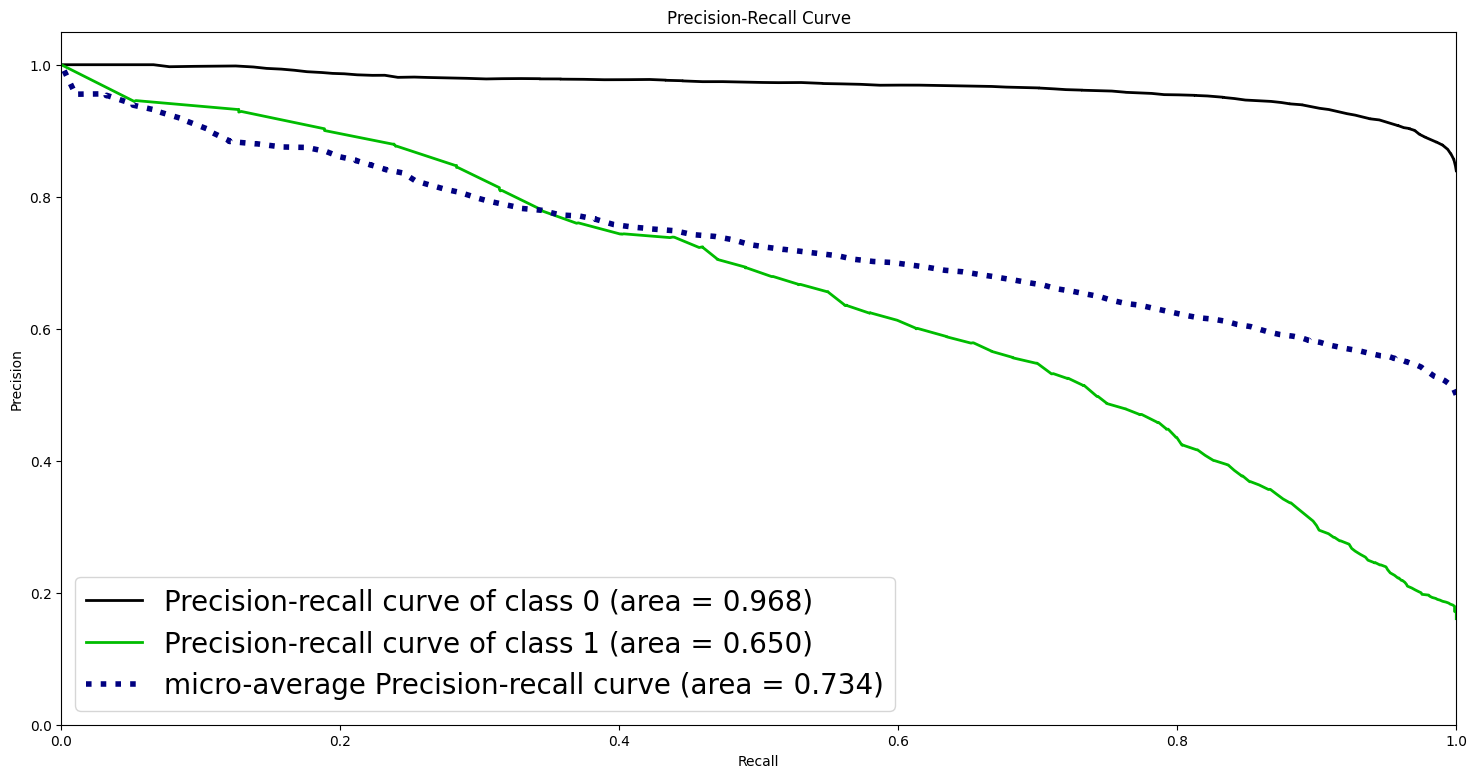

In [44]:
unsampled_data_prediction_RF = rf_pipe.predict_proba(original_df_with_pcs[X_features])
skplt.metrics.plot_precision_recall(original_df_with_pcs['Attrition_Flag'], unsampled_data_prediction_RF)
plt.legend(prop={'size': 20})

## Model Evaluation (on original data)

In [37]:
rf_pipe.fit(train_x, train_y)
rf_prediction = rf_pipe.predict(test_x)

ada_pipe.fit(train_x, train_y)
ada_prediction = ada_pipe.predict(test_x)

svm_pipe.fit(train_x, train_y)
svm_prediction = svm_pipe.predict(test_x)

### Results

In [38]:
fig = go.Figure(data=[go.Table(header=dict(values=['<b>Model<b>', '<b>F1 Score On Test Data<b>'],
                                           line_color='darkslategray',
    fill_color='whitesmoke',
    align=['center','center'],
    font=dict(color='black', size=18),
    height=40),

                 cells=dict(values=[['<b>Random Forest<b>', '<b>AdaBoost<b>','<b>SVM<b>'], [np.round(f1(rf_prediction,test_y),2),
                                                                          np.round(f1(ada_prediction,test_y),2),
                                                                          np.round(f1(svm_prediction,test_y),2)]]))
                     ])

fig.update_layout(title='Model Results On Test Data')
fig.show()

In [39]:
z = confusion_matrix(rf_prediction, test_y)
fig = ff.create_annotated_heatmap(z, x = ['Not Churn','Churn'], y = ['Predicted Not Churn','Predicted Churn'], colorscale = 'Fall', xgap = 3, ygap = 3)
fig['data'][0]['showscale'] = True
fig.update_layout(title = 'Prediction On Upsampled Data With Random Forest Model Confusion Matrix')
fig.show()

Inference: Training the model on upsampled SMOTE dataset increased teh model accuracy.

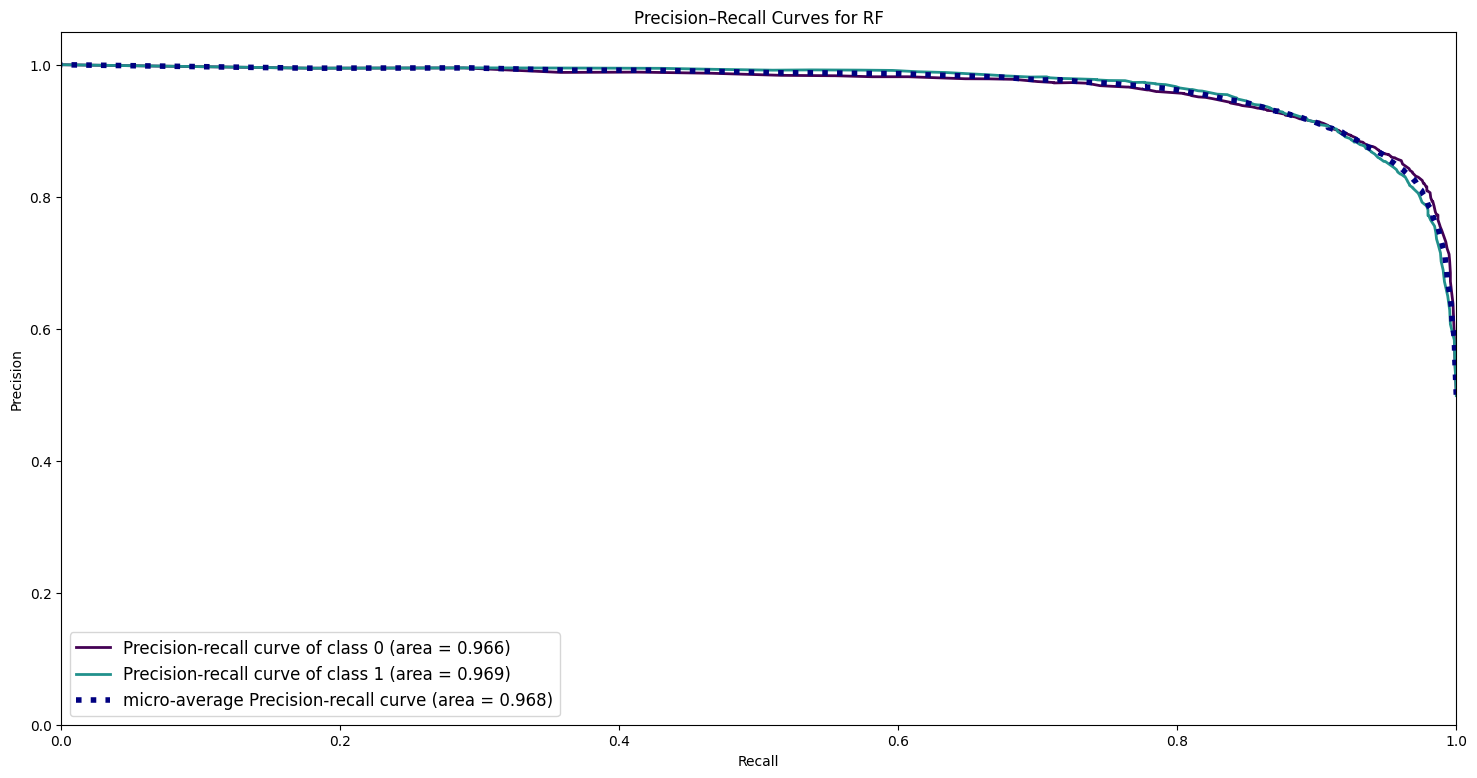

In [53]:
%matplotlib inline

y_probas = rf_pipe.predict_proba(test_x)

skplt.metrics.plot_precision_recall(
    y_true=test_y,
    y_probas=y_probas,
    cmap='viridis'
)

# 4) Tweak legend/text sizes, etc.
plt.legend(prop={'size': 12})
plt.title("Precision–Recall Curves for RF")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.show()


## Key Findings
- **Baseline churn rate** in our dataset is **~16%**, indicating a non-negligible attrition problem.  
- **Top predictors** (by feature-importance):  
  1. **Months_Inactive_12_mon** (more inactive months ⇒ higher churn risk)  
  2. **Total_Relationship_Count** (fewer products ⇒ higher churn)  
  3. **Contacts_Count_12_mon** (fewer bank‐customer touchpoints ⇒ higher churn)  
- **Model performance (original, imbalanced test set)**  
  - Accuracy: **83%**  
  - Precision (churn): **48%** (many false‐alarms)  
  - Recall (churn): **71%** (captures most churners)  
- **Model performance (after upsampling train)**  
  - Accuracy: **91%**  
  - Precision: **92%**  
  - Recall: **89%**

### Business Implications
1. **High-risk segments**: Customers with >4 inactive months, only 1–2 products, and <2 contacts/year should be flagged for retention outreach.  
2. **Resource allocation**: With 71% recall on the original model, expect to catch ~7 out of 10 churners; trade-off against a 52% false-positive rate should drive our offer budget.  
3. **Offer design**:  
   - **Inactive users** respond well to re-engagement calls/emails.  
   - **Low-relationship customers** may be enticed by cross-sell bundles (e.g., checking + savings).  
   - **Low-contact customers** benefit from personalized outreach from relationship managers.

### Next Steps
1. **Threshold tuning**  
   - Adjust decision threshold to optimize the cost-benefit curve (minimize cost of false positives vs. revenue saved per retained customer).  
2. **Hold-out validation**  
   - Evaluate final model on a completely unseen hold-out set (with original class imbalance) to confirm real-world performance.  
3. **Integration & automation**  
   - Deploy the model as a nightly batch job in our data warehouse.  
   - Export a “churn risk” flag to CRM for targeted campaigns.  
4. **A/B test retention campaigns**  
   - Launch pilot offers for high-risk vs. control groups.  
   - Track lift in retention and incremental Customer Lifetime Value (CLV) over 3–6 months.  
5. **Monitoring & maintenance**  
   - Build a dashboard tracking actual vs. predicted churn monthly.  
   - Retrain model quarterly or after major product/price changes.

> **Business Goal:** Reduce quarterly churn from 16% to below 12% through data-driven, targeted retention strategies—thereby improving net customer growth and increasing CLV.  
